In [1]:
import pandas
import seaborn
import time

from lib.compiler import Compiler
from lib.models.generic_v0.model import mappable_params

from lib.models.aft20barzur import BitcoinSM as AFT20BarZur
from lib.models.fc16sapirshtein import BitcoinSM as FC16Sapirshtein

from lib.models.generic_v1 import protocols as g1
from lib.models.generic_v1.model import SingleAgent as G1Model

from lib.models.generic_v0.bitcoin import Bitcoin as G0Bitcoin
from lib.models.generic_v0.model import SelfishMining as G0Model

In [2]:
network = mappable_params

models = []
implicit_mdps = []


def add_model(*, implicit_mdp, **model):
    models.append(model)
    implicit_mdps.append(implicit_mdp)


# related work comparison
add_model(
    scenario="reference",
    model="fc16sapirshtein",
    force_consider_own=True,
    merge_isomorphic=True,
    truncate_common_chain=True,
    collect_garbage=True,
    reward_common_chain=True,
    protocol="bitcoin",
    implicit_mdp=lambda c: FC16Sapirshtein(
        **network,
        maximum_dag_size=c,
        maximum_fork_length=0,
    ),
)

add_model(
    scenario="reference-aft20",
    model="aft20barzur",
    force_consider_own=True,
    merge_isomorphic=True,
    truncate_common_chain=True,
    collect_garbage=True,
    reward_common_chain=True,
    protocol="bitcoin",
    implicit_mdp=lambda c: AFT20BarZur(
        **network, maximum_dag_size=c, maximum_fork_length=0
    ),
)


def _():
    pass

    add_model(
        scenario="reference-v0",
        model="generic_0",
        force_consider_own=True,
        merge_isomorphic=True,
        truncate_common_chain=True,
        collect_garbage=True,
        reward_common_chain=True,
        protocol="bitcoin",
        implicit_mdp=lambda c: G0Model(
            G0Bitcoin(),
            **network,
            maximum_size=c,
            force_consider_own=True,
            merge_isomorphic=True,
        ),
    )


# our baseline: garbage collection + common chain truncation
# we want to compare to:
# - no common chain truncation (all infinite)
# - no garbage collection (infinite for protocols that allow stale blocks)
# - plus force-consider-own
# - plus merge-isomorphic
# - plus both


def add_scenario(
    scenario,
    *,
    collect_garbage=True,
    truncate_common_chain=True,
    force_consider_own=False,
    merge_isomorphic=False,
):
    def f(protocol_s, protocol_C, **protocol_args):
        model_args = dict(
            force_consider_own=force_consider_own,
            merge_isomorphic=merge_isomorphic,
            truncate_common_chain=truncate_common_chain,
            collect_garbage=collect_garbage,
            reward_common_chain=False,
        )
        add_model(
            scenario=scenario,
            model="generic_1",
            protocol=protocol_s,
            **model_args,
            implicit_mdp=lambda c: G1Model(
                protocol_C,
                **protocol_args,
                **network,
                **model_args,
                dag_size_cutoff=c,
            ),
        )

    f("bitcoin", g1.Bitcoin)
    f("ethereum_3", g1.Ethereum, h=3)
    f("byzantium_3", g1.Byzantium, h=3)
    f("ghostdag_3", g1.Ghostdag, k=3)
    f("parallel_3", g1.Parallel, k=3)


add_scenario("baseline")
# add_scenario("w/o collect garbage", collect_garbage=False)
# add_scenario("w/o truncate", truncate_common_chain=False)
add_scenario("w/ force consider", force_consider_own=True)
add_scenario("w/ normalization", merge_isomorphic=True)
add_scenario("w/ both", force_consider_own=True, merge_isomorphic=True)

models = pandas.DataFrame(models)
models

,scenario,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol
0,reference,fc16sapirshtein,True,True,True,True,True,bitcoin
1,reference-aft20,aft20barzur,True,True,True,True,True,bitcoin
2,baseline,generic_1,False,False,True,True,False,bitcoin
3,baseline,generic_1,False,False,True,True,False,ethereum_3
4,baseline,generic_1,False,False,True,True,False,byzantium_3
5,baseline,generic_1,False,False,True,True,False,ghostdag_3
6,baseline,generic_1,False,False,True,True,False,parallel_3
7,w/ force consider,generic_1,True,False,True,True,False,bitcoin
8,w/ force consider,generic_1,True,False,True,True,False,ethereum_3
9,w/ force consider,generic_1,True,False,True,True,False,byzantium_3


In [3]:
!mkdir -p 5-generated-mdps

In [4]:
from IPython.display import display, clear_output
import gc
import psutil
import pickle
import gzip

max_size = 100000
# max_size = 10000
aborts = []
size_log = []


def get_rss():
    gc.collect()
    return psutil.Process().memory_info().rss / 1024**3  # GiB


def explore(m):
    c = Compiler(m)
    while not_done := c.explore(steps=1000):
        if c.n_states > max_size:
            break
    done = not not_done
    return (done, c)


def explore_row_limit(idx, row, dag_size_limit):
    m = implicit_mdps[idx](dag_size_limit)
    start_time = time.monotonic()
    done, c = explore(m)

    info = row.to_dict() | dict(
        dag_size_limit=dag_size_limit,
        size=c.n_states,
        time_spent=time.monotonic() - start_time,
        rss=get_rss(),
    )

    # report to stdout
    print(
        "\r"
        + "\t".join(
            [
                f"{k}: {info[k]}"
                for k in [
                    "scenario",
                    "protocol",
                    "dag_size_limit",
                    "size",
                    "time_spent",
                    "rss",
                ]
            ]
            + [f"done: {done}                      "]
        ),
        end="",
    )

    if not done:
        aborts.append(info)
    else:
        mdp_key = format(abs(hash(frozenset(info.items()))), "08x")[0:8]
        size_log.append(info | dict(mdp=mdp_key))
        with gzip.open(f"5-generated-mdps/mdp-{mdp_key}.pkl.gz", "wb") as f:
            pickle.dump(c.mdp(finish_exploration=False), f)

    return done

In [5]:
for idx, row in models.iterrows():
    dag_size_limit = 1
    while True:
        dag_size_limit += 1

        if row["scenario"].startswith("reference") and dag_size_limit >= 20:
            # otherwise we'd spend to much time on the reference models
            break

        done = explore_row_limit(idx, row, dag_size_limit)
        if not done:
            break

scenario: reference	protocol: bitcoin	dag_size_limit: 2	size: 3	time_spent: 0.00022458300009020604	rss: 0.1729888916015625	done: True                      

scenario: reference	protocol: bitcoin	dag_size_limit: 5	size: 31	time_spent: 0.0010449250003148336	rss: 0.1731109619140625	done: True                      

scenario: reference	protocol: bitcoin	dag_size_limit: 6	size: 47	time_spent: 0.001619716000277549	rss: 0.1732330322265625	done: True                      

scenario: reference	protocol: bitcoin	dag_size_limit: 8	size: 90	time_spent: 0.003221729000870255	rss: 0.1733551025390625	done: True                      

scenario: reference	protocol: bitcoin	dag_size_limit: 9	size: 117	time_spent: 0.004092746999958763	rss: 0.1733551025390625	done: True                      

scenario: reference	protocol: bitcoin	dag_size_limit: 11	size: 181	time_spent: 0.006142711999927997	rss: 0.1735992431640625	done: True                      

scenario: reference	protocol: bitcoin	dag_size_limit: 12	size: 218	time_spent: 0.0074398010001459625	rss: 0.1737213134765625	done: True                      

scenario: reference	protocol: bitcoin	dag_size_limit: 14	size: 303	time_spent: 0.010305691001121886	rss: 0.1739654541015625	done: True                      

scenario: reference	protocol: bitcoin	dag_size_limit: 15	size: 351	time_spent: 0.012210763999974006	rss: 0.1739654541015625	done: True                      

scenario: reference	protocol: bitcoin	dag_size_limit: 17	size: 457	time_spent: 0.016528775000551832	rss: 0.1746978759765625	done: True                      

scenario: reference	protocol: bitcoin	dag_size_limit: 18	size: 515	time_spent: 0.018471538000085275	rss: 0.1746978759765625	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 2	size: 3	time_spent: 0.00014265900063037407	rss: 0.1748199462890625	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 3	size: 8	time_spent: 0.0002476149984431686	rss: 0.1748199462890625	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 6	size: 37	time_spent: 0.0009268529993278207	rss: 0.1748199462890625	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 7	size: 52	time_spent: 0.001315845000135596	rss: 0.1748199462890625	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 9	size: 89	time_spent: 0.0022269780001806794	rss: 0.1748199462890625	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 10	size: 111	time_spent: 0.0028155550007795682	rss: 0.1748199462890625	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 12	size: 163	time_spent: 0.004016434000732261	rss: 0.1748199462890625	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 13	size: 193	time_spent: 0.004775581001013052	rss: 0.1748199462890625	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 15	size: 260	time_spent: 0.006632132999584428	rss: 0.1748199462890625	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 16	size: 297	time_spent: 0.007510194000133197	rss: 0.1748199462890625	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 18	size: 379	time_spent: 0.012406363000991405	rss: 0.1748199462890625	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 19	size: 424	time_spent: 0.012715713999568834	rss: 0.1748199462890625	done: True                      

scenario: baseline	protocol: bitcoin	dag_size_limit: 3	size: 34	time_spent: 0.010298918999978923	rss: 0.1748199462890625	done: True                      

scenario: baseline	protocol: bitcoin	dag_size_limit: 4	size: 267	time_spent: 0.09439484500035178	rss: 0.1762847900390625	done: True                      

scenario: baseline	protocol: bitcoin	dag_size_limit: 5	size: 2332	time_spent: 1.2796306870004628	rss: 0.1909332275390625	done: True                      

scenario: baseline	protocol: bitcoin	dag_size_limit: 6	size: 21327	time_spent: 17.42204475700055	rss: 0.3449859619140625	done: True                      

scenario: baseline	protocol: bitcoin	dag_size_limit: 7	size: 100733	time_spent: 69.70458537300146	rss: 0.9971237182617188	done: False                      

scenario: baseline	protocol: ethereum_3	dag_size_limit: 3	size: 45	time_spent: 0.01898057600010361	rss: 0.21545791625976562	done: True                      

scenario: baseline	protocol: ethereum_3	dag_size_limit: 4	size: 327	time_spent: 0.13758057300037763	rss: 0.21521377563476562	done: True                      

scenario: baseline	protocol: ethereum_3	dag_size_limit: 5	size: 2981	time_spent: 1.7230636160002177	rss: 0.21502304077148438	done: True                      

scenario: baseline	protocol: ethereum_3	dag_size_limit: 6	size: 32961	time_spent: 24.555597983999178	rss: 0.4440269470214844	done: True                      

scenario: baseline	protocol: ethereum_3	dag_size_limit: 7	size: 100084	time_spent: 71.2953923590012	rss: 0.9771614074707031	done: False                      

scenario: baseline	protocol: byzantium_3	dag_size_limit: 3	size: 45	time_spent: 0.019702438001331757	rss: 0.22317886352539062	done: True                      

scenario: baseline	protocol: byzantium_3	dag_size_limit: 4	size: 327	time_spent: 0.1410338440000487	rss: 0.22269058227539062	done: True                      

scenario: baseline	protocol: byzantium_3	dag_size_limit: 5	size: 2981	time_spent: 1.7770291969991376	rss: 0.22208404541015625	done: True                      

scenario: baseline	protocol: byzantium_3	dag_size_limit: 6	size: 33016	time_spent: 25.58739658200102	rss: 0.44510650634765625	done: True                      

scenario: baseline	protocol: byzantium_3	dag_size_limit: 7	size: 100073	time_spent: 72.87999800299986	rss: 0.9772567749023438	done: False                      

scenario: baseline	protocol: ghostdag_3	dag_size_limit: 3	size: 45	time_spent: 0.0218271059984545	rss: 0.22361373901367188	done: True                      

scenario: baseline	protocol: ghostdag_3	dag_size_limit: 4	size: 352	time_spent: 0.16983917099969403	rss: 0.22361373901367188	done: True                      

scenario: baseline	protocol: ghostdag_3	dag_size_limit: 5	size: 3712	time_spent: 2.638316501999725	rss: 0.22336959838867188	done: True                      

scenario: baseline	protocol: ghostdag_3	dag_size_limit: 6	size: 46966	time_spent: 42.34511794299942	rss: 0.5433158874511719	done: True                      

scenario: baseline	protocol: ghostdag_3	dag_size_limit: 7	size: 100114	time_spent: 78.30811002100018	rss: 0.9423675537109375	done: False                      

scenario: baseline	protocol: parallel_3	dag_size_limit: 3	size: 90	time_spent: 0.031276101999537786	rss: 0.2798004150390625	done: True                      

scenario: baseline	protocol: parallel_3	dag_size_limit: 4	size: 206	time_spent: 0.07267849999880127	rss: 0.2756500244140625	done: True                      

scenario: baseline	protocol: parallel_3	dag_size_limit: 5	size: 1189	time_spent: 0.59945236600106	rss: 0.2754364013671875	done: True                      

scenario: baseline	protocol: parallel_3	dag_size_limit: 6	size: 9122	time_spent: 5.5488764239999	rss: 0.2727508544921875	done: True                      

scenario: baseline	protocol: parallel_3	dag_size_limit: 7	size: 83355	time_spent: 61.97225921599966	rss: 0.9352264404296875	done: True                      

scenario: baseline	protocol: parallel_3	dag_size_limit: 8	size: 100730	time_spent: 76.17689350500041	rss: 1.0866966247558594	done: False                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 4	size: 58	time_spent: 0.023400344000037876	rss: 0.22573089599609375	done: True                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 5	size: 186	time_spent: 0.10543943099946773	rss: 0.22548675537109375	done: True                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 6	size: 549	time_spent: 0.3111482149997755	rss: 0.22499847412109375	done: True                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 7	size: 1650	time_spent: 1.1939946029997373	rss: 0.22487640380859375	done: True                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 8	size: 4968	time_spent: 4.134301557000072	rss: 0.23195648193359375	done: True                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 9	size: 15172	time_spent: 15.111234525000327	rss: 0.33400726318359375	done: True                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 10	size: 46756	time_spent: 50.69779289899998	rss: 0.6748275756835938	done: True                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 11	size: 100126	time_spent: 100.8684796890011	rss: 1.2706832885742188	done: False                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 4	size: 78	time_spent: 0.03515464600059204	rss: 0.23386764526367188	done: True                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 5	size: 290	time_spent: 0.1528525850008009	rss: 0.23386764526367188	done: True                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 6	size: 1179	time_spent: 0.761512262000906	rss: 0.23386764526367188	done: True                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 7	size: 4123	time_spent: 3.055986800998653	rss: 0.23145294189453125	done: True                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 8	size: 15257	time_spent: 12.685577215999729	rss: 0.32630157470703125	done: True                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 9	size: 57506	time_spent: 53.55633097300051	rss: 0.7574539184570312	done: True                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 10	size: 100450	time_spent: 91.61354734299857	rss: 1.2050323486328125	done: False                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 4	size: 78	time_spent: 0.03942403600012767	rss: 0.23778915405273438	done: True                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 5	size: 290	time_spent: 0.1711047030003101	rss: 0.23778915405273438	done: True                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 6	size: 1109	time_spent: 0.8083084829995641	rss: 0.23778915405273438	done: True                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 7	size: 3850	time_spent: 3.1644527270000253	rss: 0.23778915405273438	done: True                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 8	size: 14595	time_spent: 13.575193224000031	rss: 0.3223724365234375	done: True                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 9	size: 54285	time_spent: 56.11958820200016	rss: 0.7277679443359375	done: True                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 10	size: 100686	time_spent: 100.61917326500043	rss: 1.2091865539550781	done: False                      

scenario: w/ force consider	protocol: ghostdag_3	dag_size_limit: 4	size: 84	time_spent: 0.04754234299980453	rss: 0.2406768798828125	done: True                      

scenario: w/ force consider	protocol: ghostdag_3	dag_size_limit: 5	size: 350	time_spent: 0.2636143149993586	rss: 0.2404327392578125	done: True                      

scenario: w/ force consider	protocol: ghostdag_3	dag_size_limit: 6	size: 1527	time_spent: 1.4823224709998613	rss: 0.2401885986328125	done: True                      

scenario: w/ force consider	protocol: ghostdag_3	dag_size_limit: 7	size: 6739	time_spent: 8.63039996200132	rss: 0.2434844970703125	done: True                      

scenario: w/ force consider	protocol: ghostdag_3	dag_size_limit: 8	size: 31192	time_spent: 50.23718070799987	rss: 0.4640655517578125	done: True                      

scenario: w/ force consider	protocol: ghostdag_3	dag_size_limit: 9	size: 100585	time_spent: 138.50444113999947	rss: 1.123565673828125	done: False                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 3	size: 69	time_spent: 0.027339297001162777	rss: 0.29224395751953125	done: True                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 4	size: 119	time_spent: 0.04445079200013424	rss: 0.28516387939453125	done: True                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 5	size: 470	time_spent: 0.1880797129997518	rss: 0.2844429016113281	done: True                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 6	size: 2175	time_spent: 1.1420618339998327	rss: 0.2844429016113281	done: True                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 7	size: 10337	time_spent: 5.937187796000217	rss: 0.28458404541015625	done: True                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 8	size: 43562	time_spent: 30.525345818999995	rss: 0.6078262329101562	done: True                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 9	size: 100662	time_spent: 75.61486281700127	rss: 1.1965446472167969	done: False                      

scenario: w/ normalization	protocol: bitcoin	dag_size_limit: 3	size: 45	time_spent: 0.01868195399947581	rss: 0.2508354187011719	done: True                      

scenario: w/ normalization	protocol: bitcoin	dag_size_limit: 4	size: 198	time_spent: 0.09498594899923773	rss: 0.2503471374511719	done: True                      

scenario: w/ normalization	protocol: bitcoin	dag_size_limit: 5	size: 1090	time_spent: 0.7591084760006197	rss: 0.2503471374511719	done: True                      

scenario: w/ normalization	protocol: bitcoin	dag_size_limit: 6	size: 5724	time_spent: 5.274852418999217	rss: 0.24985885620117188	done: True                      

scenario: w/ normalization	protocol: bitcoin	dag_size_limit: 7	size: 31532	time_spent: 38.39610923700093	rss: 0.4640998840332031	done: True                      

scenario: w/ normalization	protocol: bitcoin	dag_size_limit: 8	size: 100188	time_spent: 139.29914170200027	rss: 1.0938987731933594	done: False                      

scenario: w/ normalization	protocol: ethereum_3	dag_size_limit: 3	size: 78	time_spent: 0.04204756999934034	rss: 0.25640869140625	done: True                      

scenario: w/ normalization	protocol: ethereum_3	dag_size_limit: 4	size: 231	time_spent: 0.133701643000677	rss: 0.25543212890625	done: True                      

scenario: w/ normalization	protocol: ethereum_3	dag_size_limit: 5	size: 1480	time_spent: 1.1661041309998836	rss: 0.25518798828125	done: True                      

scenario: w/ normalization	protocol: ethereum_3	dag_size_limit: 6	size: 10293	time_spent: 9.956226436999714	rss: 0.268951416015625	done: True                      

scenario: w/ normalization	protocol: ethereum_3	dag_size_limit: 7	size: 77694	time_spent: 89.26413010400029	rss: 0.863067626953125	done: True                      

scenario: w/ normalization	protocol: ethereum_3	dag_size_limit: 8	size: 100621	time_spent: 113.90966789999948	rss: 1.0466766357421875	done: False                      

scenario: w/ normalization	protocol: byzantium_3	dag_size_limit: 3	size: 78	time_spent: 0.04474949900031788	rss: 0.2616424560546875	done: True                      

scenario: w/ normalization	protocol: byzantium_3	dag_size_limit: 4	size: 231	time_spent: 0.13307460800024273	rss: 0.2609100341796875	done: True                      

scenario: w/ normalization	protocol: byzantium_3	dag_size_limit: 5	size: 1480	time_spent: 1.1422206700008246	rss: 0.2606658935546875	done: True                      

scenario: w/ normalization	protocol: byzantium_3	dag_size_limit: 6	size: 9879	time_spent: 9.911419978001504	rss: 0.2649383544921875	done: True                      

scenario: w/ normalization	protocol: byzantium_3	dag_size_limit: 7	size: 72420	time_spent: 88.13920327800042	rss: 0.8114471435546875	done: True                      

scenario: w/ normalization	protocol: byzantium_3	dag_size_limit: 8	size: 100298	time_spent: 115.61322106700027	rss: 1.0496864318847656	done: False                      

scenario: w/ normalization	protocol: ghostdag_3	dag_size_limit: 3	size: 41	time_spent: 0.021061034000013024	rss: 0.2632408142089844	done: True                      

scenario: w/ normalization	protocol: ghostdag_3	dag_size_limit: 4	size: 228	time_spent: 0.13991755600000033	rss: 0.2625083923339844	done: True                      

scenario: w/ normalization	protocol: ghostdag_3	dag_size_limit: 5	size: 1581	time_spent: 1.3014938779997465	rss: 0.2617759704589844	done: True                      

scenario: w/ normalization	protocol: ghostdag_3	dag_size_limit: 6	size: 12644	time_spent: 13.794406573000742	rss: 0.2830162048339844	done: True                      

scenario: w/ normalization	protocol: ghostdag_3	dag_size_limit: 7	size: 100085	time_spent: 117.60944292400018	rss: 0.9944419860839844	done: False                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 3	size: 68	time_spent: 0.030615362999014906	rss: 0.2927818298339844	done: True                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 4	size: 152	time_spent: 0.07958401600080833	rss: 0.2920494079589844	done: True                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 5	size: 478	time_spent: 0.33197181899959105	rss: 0.2918052673339844	done: True                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 6	size: 1677	time_spent: 1.4531784239989065	rss: 0.2913169860839844	done: True                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 7	size: 6618	time_spent: 6.706488080000781	rss: 0.2883872985839844	done: True                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 8	size: 31452	time_spent: 36.25193501499962	rss: 0.4915122985839844	done: True                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 9	size: 100258	time_spent: 127.75700430799952	rss: 1.1934700012207031	done: False                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 4	size: 45	time_spent: 0.02425458000107028	rss: 0.2648773193359375	done: True                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 5	size: 120	time_spent: 0.07754827100143302	rss: 0.2639007568359375	done: True                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 6	size: 300	time_spent: 0.21766980000029434	rss: 0.2634124755859375	done: True                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 7	size: 760	time_spent: 0.6315359670006728	rss: 0.2631683349609375	done: True                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 8	size: 1959	time_spent: 2.0474748389988235	rss: 0.2631683349609375	done: True                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 9	size: 5153	time_spent: 6.068134502998873	rss: 0.2614593505859375	done: True                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 10	size: 13794	time_spent: 18.4906100219996	rss: 0.3332366943359375	done: True                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 11	size: 37322	time_spent: 57.17061522199947	rss: 0.6064300537109375	done: True                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 12	size: 100344	time_spent: 167.30746003600143	rss: 1.3441505432128906	done: False                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 4	size: 56	time_spent: 0.03549692599881382	rss: 0.2740211486816406	done: True                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 5	size: 186	time_spent: 0.13424598399979004	rss: 0.2735328674316406	done: True                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 6	size: 596	time_spent: 0.47072782699979143	rss: 0.2732887268066406	done: True                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 7	size: 1794	time_spent: 1.673981066000124	rss: 0.2728004455566406	done: True                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 8	size: 5535	time_spent: 5.98101909900106	rss: 0.2711029052734375	done: True                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 9	size: 17089	time_spent: 21.30088967300071	rss: 0.3620452880859375	done: True                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 10	size: 51668	time_spent: 70.4302908640002	rss: 0.7292327880859375	done: True                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 11	size: 100435	time_spent: 146.60971268100002	rss: 1.2637100219726562	done: False                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 4	size: 56	time_spent: 0.03716978800002835	rss: 0.280364990234375	done: True                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 5	size: 186	time_spent: 0.14235022799948638	rss: 0.280120849609375	done: True                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 6	size: 572	time_spent: 0.48975584099935077	rss: 0.280120849609375	done: True                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 7	size: 1705	time_spent: 1.7441422449992388	rss: 0.279876708984375	done: True                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 8	size: 5187	time_spent: 6.216727711000203	rss: 0.278900146484375	done: True                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 9	size: 15630	time_spent: 21.039702350999505	rss: 0.346649169921875	done: True                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 10	size: 47341	time_spent: 71.9436405739998	rss: 0.681243896484375	done: True                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 11	size: 100638	time_spent: 158.73936281500028	rss: 1.2755508422851562	done: False                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 4	size: 57	time_spent: 0.04003296699920611	rss: 0.28310394287109375	done: True                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 5	size: 184	time_spent: 0.16062526399946364	rss: 0.28237152099609375	done: True                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 6	size: 604	time_spent: 0.6574420649994863	rss: 0.28212738037109375	done: True                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 7	size: 2026	time_spent: 2.9306098750003002	rss: 0.28212738037109375	done: True                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 8	size: 6914	time_spent: 12.351482369000223	rss: 0.2800254821777344	done: True                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 9	size: 23944	time_spent: 53.00748274599937	rss: 0.4196739196777344	done: True                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 10	size: 83952	time_spent: 227.87273215999994	rss: 1.0650634765625	done: True                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 11	size: 100819	time_spent: 230.61344153500067	rss: 1.2069778442382812	done: False                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 4	size: 84	time_spent: 0.045803045000866405	rss: 0.3096961975097656	done: True                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 5	size: 195	time_spent: 0.1268376009993517	rss: 0.3084754943847656	done: True                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 6	size: 492	time_spent: 0.35508443499929854	rss: 0.3082313537597656	done: True                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 7	size: 1330	time_spent: 1.1265461289985979	rss: 0.3077430725097656	done: True                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 8	size: 3670	time_spent: 3.5590779340000154	rss: 0.3028602600097656	done: True                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 9	size: 9792	time_spent: 11.21346181500121	rss: 0.2996864318847656	done: True                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 10	size: 24547	time_spent: 33.97734205899906	rss: 0.4487342834472656	done: True                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 11	size: 59002	time_spent: 93.49982065699987	rss: 0.8647499084472656	done: True                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 12	size: 100259	time_spent: 171.52522367999882	rss: 1.3650588989257812	done: False                      

In [6]:
# locate the upper limit for exploring the reference models with binary search
for idx, row in models.iterrows():
    if not row["scenario"].startswith("reference"):
        continue

    dag_size_limit = 16
    while True:
        dag_size_limit *= 2
        done = explore_row_limit(idx, row, dag_size_limit)
        if not done:
            break

    a = dag_size_limit / 2
    b = dag_size_limit

    while b - a > 1:
        c = round((a + b) / 2)
        done = explore_row_limit(idx, row, c)
        if done:
            a = c
        else:
            b = c

scenario: reference	protocol: bitcoin	dag_size_limit: 32	size: 1698	time_spent: 0.06459968099989055	rss: 0.560394287109375	done: True                      

scenario: reference	protocol: bitcoin	dag_size_limit: 64	size: 6978	time_spent: 0.32271082399893203	rss: 0.312347412109375	done: True                      

scenario: reference	protocol: bitcoin	dag_size_limit: 128	size: 28290	time_spent: 1.2831687789985153	rss: 0.2963218688964844	done: True                      

scenario: reference	protocol: bitcoin	dag_size_limit: 256	size: 100166	time_spent: 5.05124356899978	rss: 0.3409996032714844	done: False                      

scenario: reference	protocol: bitcoin	dag_size_limit: 192	size: 63938	time_spent: 3.0659316210003453	rss: 0.2953147888183594	done: True                      

scenario: reference	protocol: bitcoin	dag_size_limit: 224	size: 87138	time_spent: 4.200527289998718	rss: 0.3156852722167969	done: True                      

scenario: reference	protocol: bitcoin	dag_size_limit: 240	size: 100012	time_spent: 4.784680644999753	rss: 0.33979034423828125	done: False                      

scenario: reference	protocol: bitcoin	dag_size_limit: 232	size: 93498	time_spent: 4.281842337999478	rss: 0.3299980163574219	done: True                      

scenario: reference	protocol: bitcoin	dag_size_limit: 236	size: 96762	time_spent: 4.70776993400068	rss: 0.3349151611328125	done: True                      

scenario: reference	protocol: bitcoin	dag_size_limit: 238	size: 98415	time_spent: 4.404343959000471	rss: 0.3373603820800781	done: True                      

scenario: reference	protocol: bitcoin	dag_size_limit: 239	size: 99247	time_spent: 4.911670049999884	rss: 0.33861541748046875	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 32	size: 1233	time_spent: 0.03301399900010438	rss: 0.2958030700683594	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 64	size: 5025	time_spent: 0.13656544999867037	rss: 0.292938232421875	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 128	size: 20289	time_spent: 0.7358247829997708	rss: 0.2920188903808594	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 256	size: 81537	time_spent: 3.183140937000644	rss: 0.2980003356933594	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 512	size: 100709	time_spent: 3.75153499299995	rss: 0.3070945739746094	done: False                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 384	size: 100709	time_spent: 3.4622216900006606	rss: 0.3071861267089844	done: False                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 320	size: 100709	time_spent: 3.5110014290003164	rss: 0.30718994140625	done: False                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 288	size: 100709	time_spent: 3.586033215999123	rss: 0.307098388671875	done: False                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 272	size: 92073	time_spent: 3.2316498999989562	rss: 0.2986640930175781	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 280	size: 97581	time_spent: 3.4299932699996134	rss: 0.3038825988769531	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 284	size: 100395	time_spent: 3.4647137749998365	rss: 0.3069572448730469	done: False                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 282	size: 98983	time_spent: 3.4813294369996584	rss: 0.3054389953613281	done: True                      

scenario: reference-aft20	protocol: bitcoin	dag_size_limit: 283	size: 99688	time_spent: 3.4730242719997477	rss: 0.3062705993652344	done: True                      

In [7]:
size_log = pandas.DataFrame(size_log)
aborts = pandas.DataFrame(aborts)

size_log.to_pickle("5-generated-mdps/success.pkl.gz")
aborts.to_pickle("5-generated-mdps/fail.pkl.gz")

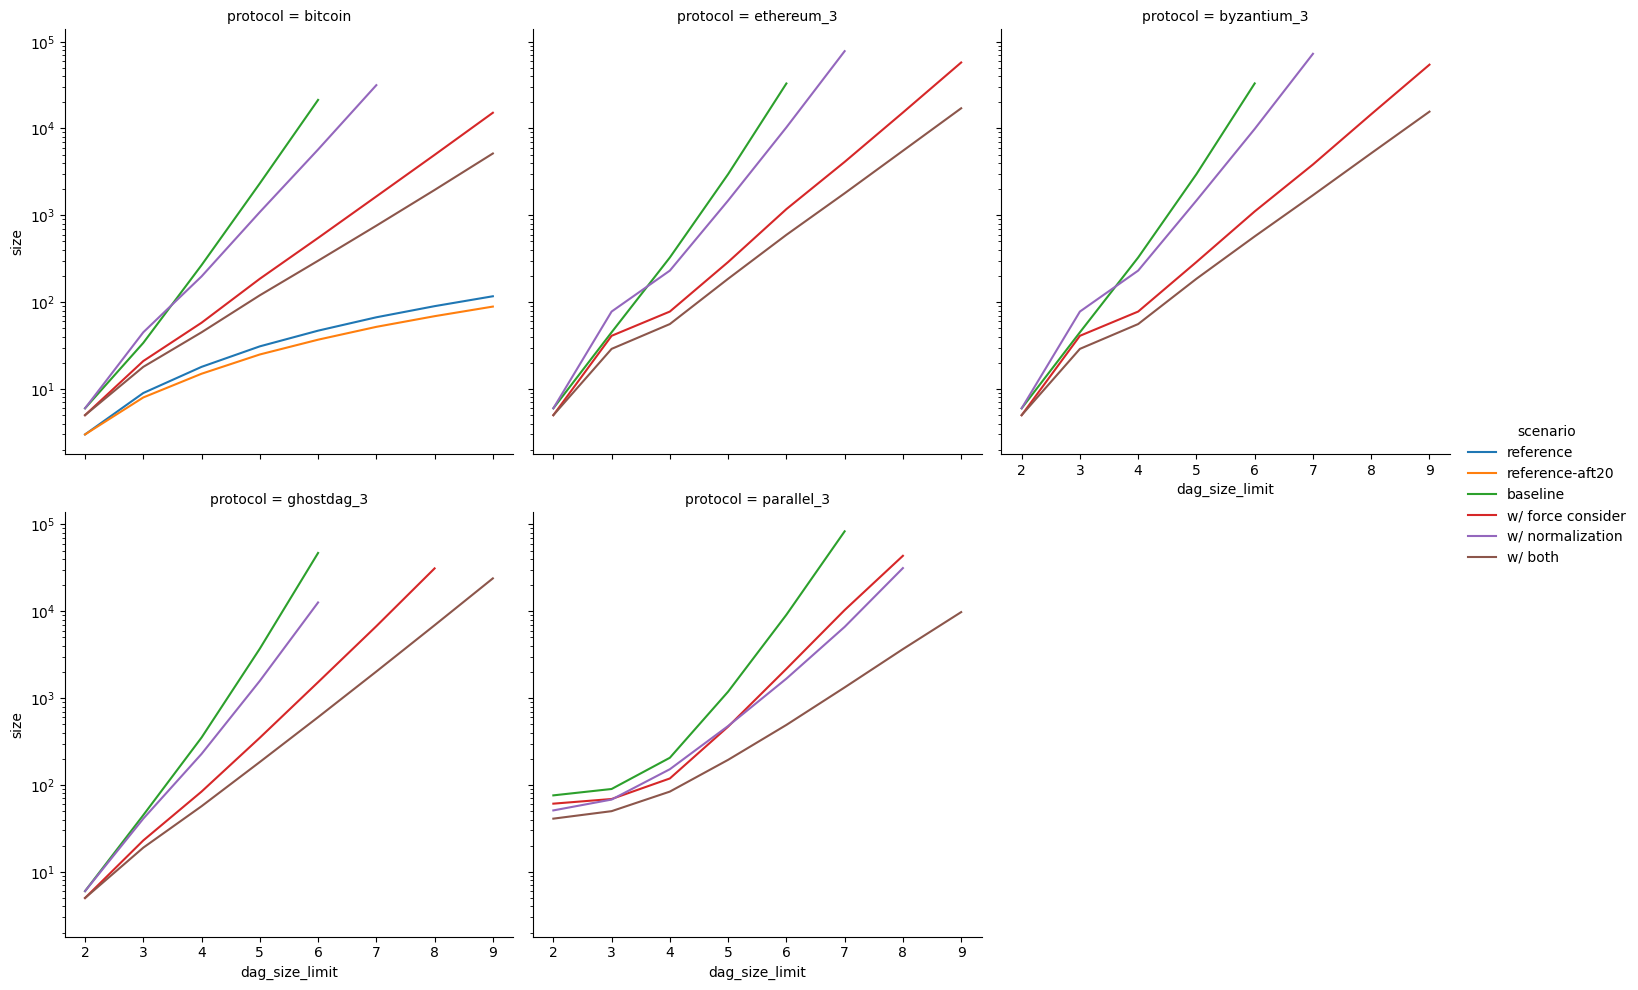

In [8]:
seaborn.relplot(
    data=size_log.query("dag_size_limit < 10"),
    kind="line",
    x="dag_size_limit",
    y="size",
    hue="scenario",
    col="protocol",
    col_wrap=3,
).set(yscale="log")